In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, Image
import ipywidgets
import numpy
import pandas
from matplotlib import cm, pyplot

import calibr8
import dataloading
import models
import plotting

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


In [3]:
cm360 = models.LogisticBiomassAbsorbanceModel.load("cm_biomass_A360.json")
cm600 = models.LogisticBiomassAbsorbanceModel.load("cm_biomass_A600.json")

df_layout = dataloading.get_layout(
    r"multibatch\FullWellDescription.xlsx",
    design_cols=["iptg", "glucose"]
)
df_time, df_A360, df_A600 = dataloading.vectorize_observations(
    df_layout,
    observations={
        f"Carboxylase_{v}": (
            dataloading.read_absorbances(rf"multibatch\Carboxylase_{v}_360nm.csv"),
            dataloading.read_absorbances(rf"multibatch\Carboxylase_{v}_600nm.csv"),
        )
        for v in [19, 20, 21]
    }
)
df_commons = dataloading.count_replicates(df_layout)

display(df_layout.head())
display(df_A360.head())
display(df_commons.head())

90 rows were dropped because a product concentration was unknown AND information in columns ['iptg', 'glucose'] was incomplete.


,run,assay_well,reactor,group,product,biomass,iptg,glucose,design_id
replicate_id,,,,,,,,,
ZR7B9,Carboxylase_19,A01,A1,0.15/4.8,NaN,NaN,0.15,4.8,6R3K4
8Z9AE,Carboxylase_19,A02,A2,0.25/4.8,NaN,NaN,0.25,4.8,LCFQ6
44TX5,Carboxylase_19,A03,A3,0.40/4.8,NaN,NaN,0.40,4.8,7PK4B
11HM9,Carboxylase_19,A04,A4,0.60/4.8,NaN,NaN,0.60,4.8,XTBYB
CKTKC,Carboxylase_19,A05,A5,0.80/4.8,NaN,NaN,0.80,4.8,D6NHA


cycle,0,1,2,3,4
replicate_id,,,,,
ZR7B9,0.571,0.869,1.153,1.488,2.132
8Z9AE,0.558,0.847,1.122,1.575,2.029
44TX5,0.579,0.896,1.172,1.476,2.018
11HM9,0.546,0.897,1.184,1.507,2.017
CKTKC,0.640,0.949,1.237,1.496,1.899


,,Carboxylase_19,Carboxylase_20,Carboxylase_21,n_replicates,redundancy
design_id,group,,,,,
8F7WM,2.0/4.8,4,4,0,8,✅ (2)
9N38N,1.5/4.8,3,4,0,7,✅ (2)
FE35K,0.75/2.0,0,0,4,4,❌
D6NHA,0.80/4.8,4,0,0,4,❌
9DCAW,0.50/4.8,4,0,0,4,❌


# Explorative analysis of biotransformation experiments
As we can see above there are just few designs that are tested in more than one run, even though each design is tested 4x _per_ run. This design will make it harder to understand batch-effects.

Before coding up the process model, it is a good idea to make explorative plots of the data to identify which effects have to be accounted for.

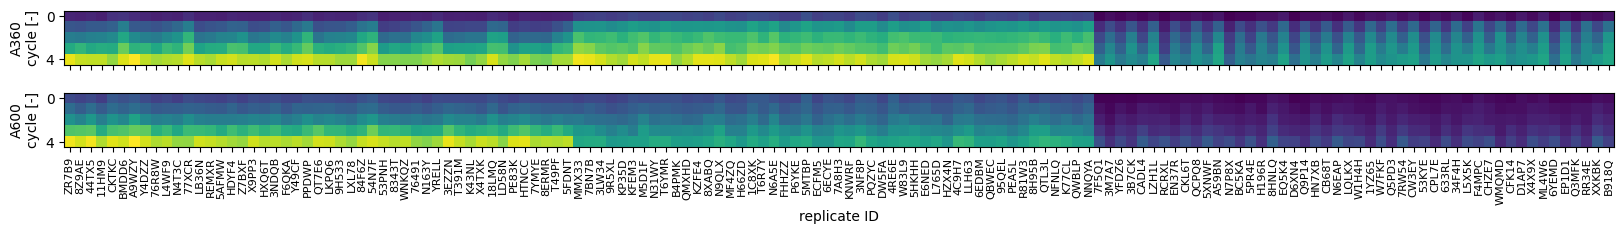

In [4]:
fig, axs = plotting.plot_absorbance_heatmap(df_layout, df_A360, df_A600)
pyplot.show()

The next cell is an interactive plot for comparing absorbance kinetics within the same group of replicates.

In [5]:
def plot(group="2.0/4.8"):
    plotting.plot_group_kinetics(df_layout, df_time, df_A360, df_A600, group)
    return pyplot.show()

ipywidgets.interact(
    plot,
    group=numpy.unique(df_layout["group"].dropna())
);

interactive(children=(Dropdown(description='group', index=19, options=('0.15/4.8', '0.20/4.8', '0.25/4.8', '0.…

Higher product concentrations inhibit biomass growth.

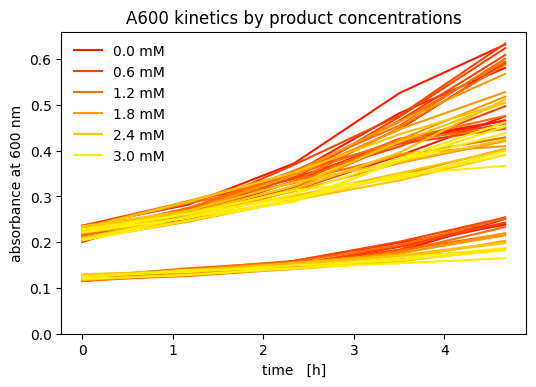

In [6]:
plotting.plot_calibration_A600(df_layout, df_A600, df_time)
pyplot.show()

We don't have separate calibration data for product concentration vs. 360 nm absorbance.
In the process model we'll make up for that by assuming a linear relationship between product concentration and 360 nm absorbance:

$$\mathrm{A_{product,\ 360\ nm}} \propto [P]$$

The following cells try to plot this relationship such that we can make a rough prior guess of the corresponding proportionality constant.

⚠ Unfortunately even after subtracting the biomass contribution to the 360 nm absorbance there remains an increase in $A_{360\ nm}$ over time.

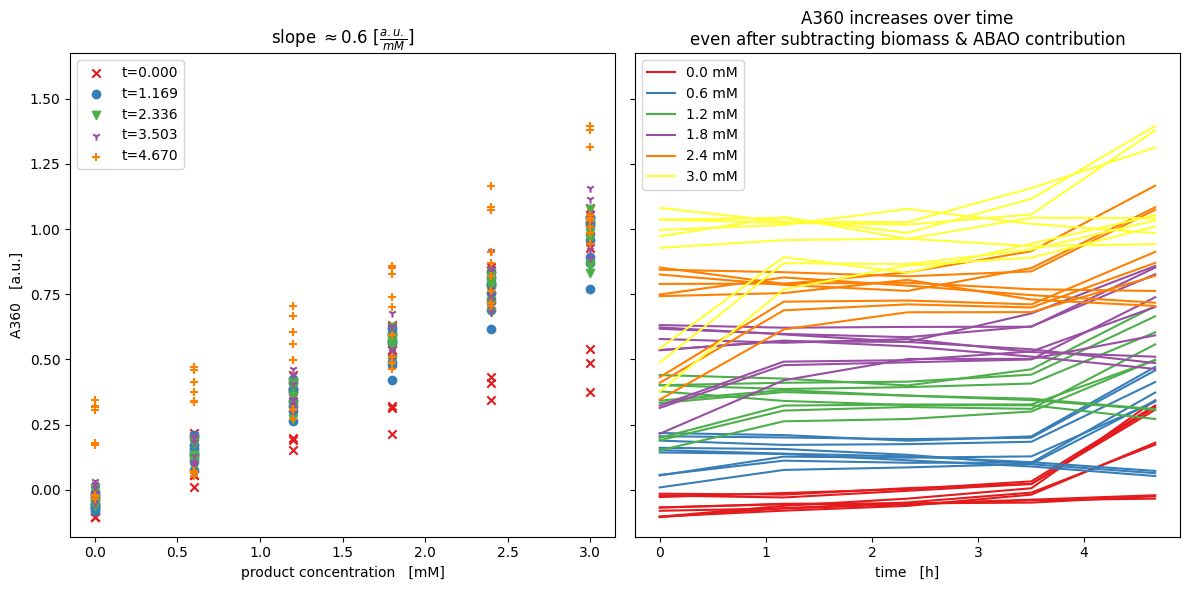

In [7]:
plotting.plot_calibration_A360(df_layout, df_time, df_A360, df_A600, cm360, cm600)
pyplot.show()

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Oct 13 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.22.0

matplotlib: 3.4.2
calibr8   : 6.1.0
numpy     : 1.21.0
ipywidgets: 7.6.3
pandas    : 1.3.0

Watermark: 2.2.0

